In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path
classLabels = ["desert", "mountains", "sea", "sunset", "trees" ]
print(torch.__version__)

1.0.1.post2


## Download Data

In [0]:
!curl -q -L 'https://drive.google.com/uc?export=download&id=0B-K4r5JAJoL1MTRkM1RodlZ6d0ExakZoNmp5TFdOeTY0VFFj' -o data.zip
#from google.colab import files
#files.upload()
!unzip -q image_scene_data.zip & rm image_scene_data.zip

sample_data


## Structure the data

In [0]:
!ls

sample_data


In [0]:
df = pd.DataFrame({"image": sorted([ int(x.name.strip(".jpg")) for x in Path("original").iterdir()])})
df.image = df.image.astype(np.str)
print(df.dtypes)
df.image = df.image.str.cat([".jpg"]*len(df))
for label in classLabels:
  df[label]=0
with open("labels.json") as infile:
    s ="["
    s = s + ",".join(infile.readlines())
    s = s+"]"
    s = np.array(eval(s))
    s[s<0] = 0
    df.iloc[:,1:] = s
df.to_csv("data.csv",index=False)
print(df.head(10))
del df

image    object
dtype: object
    image  desert  mountains  sea  sunset  trees
0   1.jpg       1          0    0       0      0
1   2.jpg       1          0    0       0      0
2   3.jpg       1          0    0       0      0
3   4.jpg       1          1    0       0      0
4   5.jpg       1          0    0       0      0
5   6.jpg       1          0    0       0      0
6   7.jpg       1          1    0       0      0
7   8.jpg       1          0    0       0      0
8   9.jpg       1          0    0       0      0
9  10.jpg       1          1    0       0      0


## Visulaize the data


### Data distribution

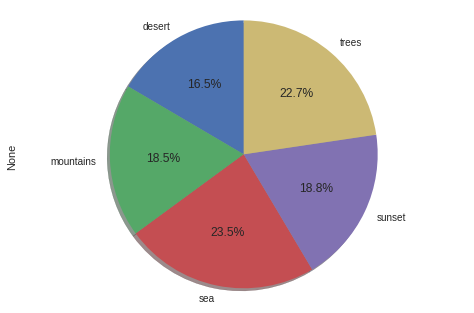

In [0]:
df = pd.read_csv("data.csv")
fig1, ax1 = plt.subplots()
df.iloc[:,1:].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

### Correlation between different classes

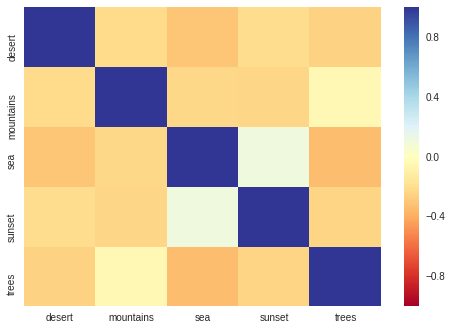

In [0]:
import seaborn as sns
sns.heatmap(df.iloc[:,1:].corr(), cmap="RdYlBu", vmin=-1, vmax=1)
# looks like there is no correlation between the labels

### Visualize images

53.jpg


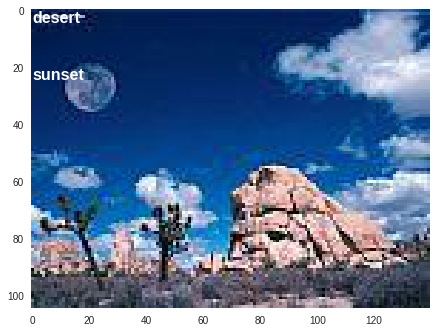

In [0]:
def visualizeImage(idx):
  fd = df.iloc[idx]
  image = fd.image
  label = fd[1:].tolist()
  print(image)
  image = Image.open("original/"+image)
  fig,ax = plt.subplots()
  ax.imshow(image)
  ax.grid(False)
  classes =  np.array(classLabels)[np.array(label,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
  plt.show()

visualizeImage(52)

In [0]:
#Images in the dataset have different sizes to lets take a mean size while resizing 224*224
l= []
for i in df.image:
  with Image.open(Path("original")/i) as f:
    l.append(f.size)
np.array(l).mean(axis=0),np.median(np.array(l) , axis=0)

(array([263.7145, 211.46  ]), array([256., 256.]))

## Create Data pipeline

In [0]:
class MyDataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None ):
    
    self.df = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transforms = transforms
    
  def __getitem__(self,idx):
    d = self.df.iloc[idx.item()]
    image = Image.open(self.img_dir/d.image).convert("RGB")
    label = torch.tensor(d[1:].tolist() , dtype=torch.float32)
    
    if self.transforms is not None:
      image = self.transforms(image)
    return image,label
  
  def __len__(self):
    return len(self.df)

In [0]:
batch_size=32
transform = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

dataset = MyDataset("data.csv" , Path("original") , transform)
valid_no = int(len(dataset)*0.12) 
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])
print(f"trainset len {len(trainset)} valset len {len(valset)}")
dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

trainset len 1760 valset len 240


## Model Definition

In [0]:
model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)
## freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)

2048


In [0]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
  features_lst = [num_features , num_features//2 , num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

top_head = create_head(num_features , len(classLabels)) # because ten classes
model.fc = top_head # replace the fully connected layer

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Optimizer and Criterion

In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

## Training

In [0]:
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
        scheduler.step()
      else:     # put the model in validation mode
        model.eval()
       
      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0  
      
      for data , target in data_loader[phase]:
        #load the data and target to respective device
        data , target = data.to(device)  , target.to(device)

        with torch.set_grad_enabled(phase=="train"):
          #feed the input
          output = model(data)
          #calculate the loss
          loss = criterion(output,target)
          preds = torch.sigmoid(output).data > 0.5
          preds = preds.to(torch.float32)
          
          if phase=="train"  :
            # backward pass: compute gradient of the loss with respect to model parameters 
            loss.backward()
            # update the model parameters
            optimizer.step()
            # zero the grad to stop it from accumulating
            optimizer.zero_grad()


        # statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
        
        
      epoch_loss = running_loss / len(data_loader[phase].dataset)
      epoch_acc = running_corrects / len(data_loader[phase].dataset)

      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print(result)

In [0]:
train(model,dataloader , criterion, optimizer,sgdr_partial,num_epochs=10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
Epochs:  10%|█         | 1/10 [00:26<03:57, 26.38s/it]

['train Loss: 0.4075 Acc: 0.7448', 'val Loss: 0.2672 Acc: 0.8422']


Epochs:  20%|██        | 2/10 [00:52<03:31, 26.38s/it]

['train Loss: 0.2319 Acc: 0.8373', 'val Loss: 0.1947 Acc: 0.8374']


Epochs:  30%|███       | 3/10 [01:19<03:04, 26.35s/it]

['train Loss: 0.2051 Acc: 0.8161', 'val Loss: 0.2124 Acc: 0.8019']


Epochs:  40%|████      | 4/10 [01:45<02:38, 26.36s/it]

['train Loss: 0.2024 Acc: 0.8296', 'val Loss: 0.2127 Acc: 0.8171']


Epochs:  50%|█████     | 5/10 [02:11<02:11, 26.32s/it]

['train Loss: 0.1885 Acc: 0.8439', 'val Loss: 0.2123 Acc: 0.8289']


Epochs:  60%|██████    | 6/10 [02:37<01:45, 26.32s/it]

['train Loss: 0.1728 Acc: 0.8558', 'val Loss: 0.1860 Acc: 0.8379']


Epochs:  70%|███████   | 7/10 [03:04<01:18, 26.30s/it]

['train Loss: 0.1668 Acc: 0.8643', 'val Loss: 0.1976 Acc: 0.8462']


Epochs:  80%|████████  | 8/10 [03:30<00:52, 26.33s/it]

['train Loss: 0.1595 Acc: 0.8667', 'val Loss: 0.2169 Acc: 0.8318']


Epochs:  90%|█████████ | 9/10 [03:57<00:26, 26.35s/it]

['train Loss: 0.1311 Acc: 0.8915', 'val Loss: 0.1724 Acc: 0.8885']


Epochs: 100%|██████████| 10/10 [04:23<00:00, 26.36s/it]

['train Loss: 0.1301 Acc: 0.8969', 'val Loss: 0.1794 Acc: 0.8622']


## Saving & Loading model

In [0]:
def createCheckpoint(filename=Path("./LatestCheckpoint.pt")):
  checkpoint = {
              'epoch': 5,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
  } # save all important stuff
  torch.save(checkpoint , filename)
createCheckpoint()

In [0]:
# Load
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

'''

checkpoint = torch.load(Path("./LatestCheckpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.0013819660112501051
    weight_decay: 0
)

## LrFinder and One Cycle Policy

For faster convergence 

In [0]:
def unfreeze(model,percent=0.25):
  l = int(np.ceil(len(model._modules.keys())* percent))
  l = list(model._modules.keys())[-l:]
  print(f"unfreezing these layer {l}",)
  for name in l:
    for params in model._modules[name].parameters():
      params.requires_grad_(True)

def check_freeze(model):
  for name ,layer in model._modules.items():
    s = []
    for l in layer.parameters():
      s.append(l.requires_grad)
    print(name ,all(s))

In [0]:
# unfreeze 40% of the model
unfreeze(model ,0.40)
# check which layer is freezed or not
check_freeze(model)


unfreezing these layer ['layer3', 'layer4', 'avgpool', 'fc']
conv1 False
bn1 False
relu True
maxpool True
layer1 False
layer2 False
layer3 True
layer4 True
avgpool True
fc True


### LR finder

In [0]:
class LinearScheduler(lr_scheduler._LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of iterations."""
    def __init__(self, optimizer, end_lr, num_iter):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearScheduler,self).__init__(optimizer)

    def get_lr(self):
        # increement one by one
        curr_iter = self.last_epoch + 1
        # get the ratio
        pct = curr_iter / self.num_iter
        # calculate lr with this formulae start + pct * (end-start)
        return [base_lr + pct * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialScheduler(lr_scheduler._LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of iterations."""

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialScheduler,self).__init__(optimizer)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        pct = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** pct for base_lr in self.base_lrs]
      
class CosineScheduler(lr_scheduler._LRScheduler):
    """Cosine increases the learning rate between two boundaries over a number of iterations."""

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(CosineScheduler,self).__init__(optimizer)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        pct = curr_iter / self.num_iter
        cos_out = np.cos(np.pi * pct) + 1
        return [self.end_lr + (base_lr - self.end_lr )/2 *cos_out for base_lr in self.base_lrs]

In [0]:
class LRFinder:
  
  def __init__(self, model  , optimizer , criterion ,start_lr=1e-7, device=None):
    
    self.model = model
    # Move the model to the proper device
    self.optimizer = optimizer
    self.criterion = criterion
    
    ## save the model intial dict
    self.save_file = Path("tmpfile")
    torch.save(self.model , self.save_file)    
    if device is None:
      self.device = next(model.parameters()).device
    else:
      self.device = device
    self.model.to(self.device)
    
    self.history = {"lr":[] , "losses":[]}
    for l in self.optimizer.param_groups:
      l["initial_lr"]=start_lr
    
    
  def reset(self):
    """ Resets the model to intial state """
    self.model = torch.load(self.save_file)
    self.model.train()
    self.save_file.unlink()
    print("model reset done")
    return self.model
    
  def calculateSmmothingValue(self ,beta):
    n ,mov_avg=0,0
    while True :
      n+=1
      value = yield
      mov_avg = beta*mov_avg +(1-beta)*value
      smooth = mov_avg / (1 - beta **n )
      yield smooth
    
  def lrfind(self, trainLoader,end_lr=10,num_iter=150,step_mode="exp", loss_smoothing_beta=0.99, diverge_th=5): 
        """
         Performs the lrfind test

         Arguments:
            trainLoader : The data loader
            end_lr :  The maximum lr
            num_iter : Max iteratiom
            step_mode : The anneal function by default `exp` but can be either `linear` or `cos`
            smooth_f : The loss smoothing factor, value should be between [0 , 1[
            diverge_th: The max loss value after which training should be stooped
        """
              # Reset test results
        self.history = {"lr": [], "losses": []}
        self.best_loss = None
        self.smoothner = self.calculateSmmothingValue(loss_smoothing_beta)
        
        if step_mode.lower()=="exp":
          lr_schedule = ExponentialScheduler(self.optimizer , end_lr  , num_iter,)
        elif step_mode.lower()=="cos":
          lr_schedule = CosineScheduler(self.optimizer , end_lr  , num_iter)
        elif step.mode.lower()=="linear":
          lr_schedule = LinearScheduler(self.optimizer , end_lr  , num_iter)
        else:
          raise ValueError(f"expected mode is either {exp , cos ,linear} got {step_mode}")
        
        if 0 < loss_smoothing_beta >=1:
          raise ValueError("smooth_f is outside the range [0, 1[")
        
        iterator = iter(trainLoader)
        for each_iter in range(num_iter):
          try:
            data , target = next(iterator)
          except StopIteration:
            iterator = iter(trainLoader)
            data , target = next(iterator)
         
          loss = self._train_batch(data , target)
          
          # Update the learning rate
          lr_schedule.step()
          self.history["lr"].append(lr_schedule.get_lr()[0])
          # Track the best loss and smooth it if smooth_f is specified
          if each_iter == 0:
              self.best_loss = loss
          else:
              next(self.smoothner)
              self.best_loss = self.smoothner.send(loss)
              if loss < self.best_loss:
                  self.best_loss = loss

          # Check if the loss has diverged; if it has, stop the test
          self.history["losses"].append(loss)
          if loss > diverge_th * self.best_loss:
              print("Stopping early, the loss has diverged")
              break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")            
  
  def _train_batch(self,data,target):
    # set to training mode
    self.model.train()
    #load data to device
    data ,target = data.to(self.device) ,target.to(self.device)
    
    #forward pass
    self.optimizer.zero_grad()
    output = self.model(data)
    loss = self.criterion(output,target)
    
    #backward pass
    loss.backward()
    self.optimizer.step()
    return loss.item()
  
  def plot(self):
    losses = self.history["losses"]
    lr = self.history["lr"]
    plt.semilogx(lr,losses)
    plt.xlabel("Learning rate")
    plt.ylabel("Losses ")
    plt.show()

In [0]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.lrfind(dataloader["train"], end_lr=10, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


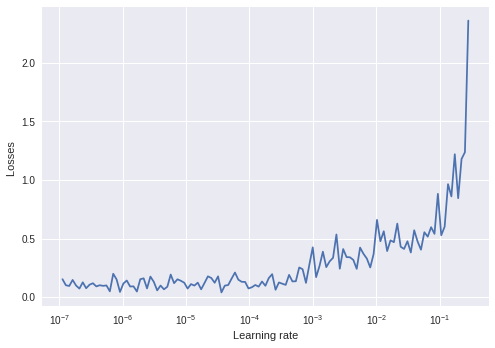

model reset done


In [0]:
lr_finder.plot()
model= lr_finder.reset()

###  One Cycle Policy

In [0]:
class Stepper():
    "Used to \"step\" from start,end (`vals`) over `n_iter` iterations on a schedule defined by `func`"
    
    def __init__(self, val, n_iter:int, func):
        self.start,self.end = val
        self.n_iter = max(1,n_iter)
        self.func = func
        self.n = 0

    def step(self):
        "Return next value along annealed schedule."
        self.n += 1
        return self.func(self.start, self.end, self.n/self.n_iter)

    @property
    def is_done(self):
        "Return `True` if schedule completed."
        return self.n >= self.n_iter
    
# Annealing functions
def annealing_no(start, end, pct):
    "No annealing, always return `start`."
    return start
  
def annealing_linear(start, end, pct):
    "Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start + pct * (end-start)
  
def annealing_exp(start, end, pct):
    "Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start * (end/start) ** pct

def annealing_cos(start, end, pct):
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out

In [0]:


class OneCyclePolicy:
  
  def __init__(self,model , optimizer , criterion ,num_iteration,num_epochs,max_lr, momentum = (0.95,0.85) , div_factor=25 , pct_start=0.4, device=None ):
    
    self.model =model
    self.optimizer = optimizer
    self.criterion = criterion
    self.num_epochs = num_epochs
    if device is None:
      self.device = next(model.parameters()).device
    else:
      self.device = device
      
    n = num_iteration * self.num_epochs
    a1 = int(n*pct_start)
    a2 = n-a1
    self.phases = ((a1 , annealing_linear) , (a2 , annealing_cos))
    min_lr = max_lr/div_factor
    self.lr_scheds = self.steps((min_lr,max_lr) , (max_lr,min_lr/1e4))
    self.mom_scheds = self.steps(momentum , momentum[::-1])
    self.idx_s = 0
    self.update_lr_mom(self.lr_scheds[0].start,self.mom_scheds[0].start)
  
  def steps(self, *steps):
      "Build anneal schedule for all of the parameters."
      return [Stepper(step, n_iter, func=func)for (step,(n_iter,func)) in zip(steps, self.phases)]

  def train(self, trainLoader , validLoader ):
    self.model.to(self.device)
    data_loader = {"train":trainLoader , "val":validLoader}
    for epoch in trange(self.num_epochs,desc="Epochs"):
      result = []
      for phase in ['train', 'val']:
        if phase=="train":     # put the model in training mode
          model.train()
        else:     # put the model in validation mode
          model.eval()

        # keep track of training and validation loss
        running_loss = 0.0
        running_corrects = 0  

        for data , target in data_loader[phase]:
          #load the data and target to respective device
          data , target = data.to(device)  , target.to(device)

          with torch.set_grad_enabled(phase=="train"):
            #feed the input
            output = self.model(data)
            #calculate the loss
            loss = self.criterion(output,target)
            preds = torch.sigmoid(output).data > 0.5
            preds = preds.to(torch.float32)

            if phase=="train"  :
              # backward pass: compute gradient of the loss with respect to model parameters 
              loss.backward()
              # update the model parameters
              self.optimizer.step()
              # zero the grad to stop it from accumulating
              self.optimizer.zero_grad()
              self.update_lr_mom(self.lr_scheds[self.idx_s].step() ,self.mom_scheds[self.idx_s].step() )

              if self.lr_scheds[self.idx_s].is_done:
                self.idx_s += 1
          
          # statistics
          running_loss += loss.item() * data.size(0)
          running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)


        epoch_loss = running_loss / len(data_loader[phase].dataset)
        epoch_acc = running_corrects/ len(data_loader[phase].dataset)

        result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      print(result)

  def update_lr_mom(self,lr=0.001,mom=0.99):
    for l in self.optimizer.param_groups:
      l["lr"]=lr
      if isinstance(self.optimizer , ( torch.optim.Adamax,torch.optim.Adam)):
          l["betas"] = ( mom, 0.999)
      elif isinstance(self.optimizer, torch.optim.SGD):
          l["momentum"] =mom

In [0]:
fit_one_cycle = OneCyclePolicy(model ,optimizer , criterion,num_iteration=len(dataloader["train"].dataset)//batch_size  , num_epochs =8, max_lr =1e-5 ,device=device)
fit_one_cycle.train(dataloader["train"],dataloader["val"])

Epochs:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
Epochs:  12%|█▎        | 1/8 [00:40<04:46, 40.96s/it]

['train Loss: 0.1204 Acc: 0.9024', 'val Loss: 0.2133 Acc: 0.8635']


Epochs:  25%|██▌       | 2/8 [01:21<04:05, 40.90s/it]

['train Loss: 0.1215 Acc: 0.9038', 'val Loss: 0.1918 Acc: 0.8699']


Epochs:  38%|███▊      | 3/8 [02:02<03:24, 40.85s/it]

['train Loss: 0.1131 Acc: 0.9144', 'val Loss: 0.2198 Acc: 0.8621']


Epochs:  50%|█████     | 4/8 [02:43<02:43, 40.81s/it]

['train Loss: 0.1108 Acc: 0.9105', 'val Loss: 0.2151 Acc: 0.8608']


Epochs:  62%|██████▎   | 5/8 [03:23<02:02, 40.80s/it]

['train Loss: 0.1165 Acc: 0.9090', 'val Loss: 0.1702 Acc: 0.8711']


Epochs:  75%|███████▌  | 6/8 [04:04<01:21, 40.78s/it]

['train Loss: 0.1172 Acc: 0.9046', 'val Loss: 0.1985 Acc: 0.8635']


Epochs:  88%|████████▊ | 7/8 [04:45<00:40, 40.78s/it]

['train Loss: 0.1201 Acc: 0.9098', 'val Loss: 0.2220 Acc: 0.8699']


Epochs: 100%|██████████| 8/8 [05:26<00:00, 40.81s/it]

['train Loss: 0.1187 Acc: 0.9028', 'val Loss: 0.2127 Acc: 0.8621']


## unfreeze 60 % architecture and retrain

In [0]:
# unfreeze 60% of the model
unfreeze(model ,0.60)
# check which layer is freezed or not
check_freeze(model)


unfreezing these layer ['layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
conv1 False
bn1 False
relu True
maxpool True
layer1 True
layer2 True
layer3 True
layer4 True
avgpool True
fc True


In [0]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.lrfind(dataloader["train"], end_lr=10, step_mode="exp")

Learning rate search finished. See the graph with {finder_name}.plot()


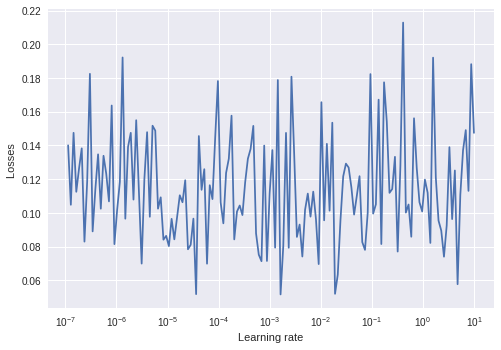

In [0]:
lr_finder.plot()

In [0]:
model= lr_finder.reset()

model reset done


In [0]:
fit_one_cycle = OneCyclePolicy(model ,optimizer , criterion,num_iteration=len(dataloader["train"].dataset)//batch_size  , num_epochs =10, max_lr =1e-5 ,device=device)
fit_one_cycle.train(dataloader["train"],dataloader["val"])

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
Epochs:  10%|█         | 1/10 [00:54<08:06, 54.03s/it]

['train Loss: 0.1165 Acc: 0.9087', 'val Loss: 0.1733 Acc: 0.8621']


Epochs:  20%|██        | 2/10 [01:48<07:12, 54.04s/it]

['train Loss: 0.1141 Acc: 0.9082', 'val Loss: 0.1731 Acc: 0.8775']


Epochs:  30%|███       | 3/10 [02:42<06:18, 54.06s/it]

['train Loss: 0.1153 Acc: 0.9125', 'val Loss: 0.2097 Acc: 0.8649']


Epochs:  40%|████      | 4/10 [03:36<05:24, 54.10s/it]

['train Loss: 0.1162 Acc: 0.9106', 'val Loss: 0.2150 Acc: 0.8657']


Epochs:  50%|█████     | 5/10 [04:30<04:30, 54.15s/it]

['train Loss: 0.1191 Acc: 0.9111', 'val Loss: 0.1801 Acc: 0.8690']


Epochs:  60%|██████    | 6/10 [05:24<03:36, 54.18s/it]

['train Loss: 0.1149 Acc: 0.9051', 'val Loss: 0.2128 Acc: 0.8621']


Epochs:  70%|███████   | 7/10 [06:19<02:42, 54.18s/it]

['train Loss: 0.1218 Acc: 0.9079', 'val Loss: 0.1721 Acc: 0.8697']


Epochs:  80%|████████  | 8/10 [07:13<01:48, 54.13s/it]

['train Loss: 0.1150 Acc: 0.9081', 'val Loss: 0.1749 Acc: 0.8650']


Epochs:  90%|█████████ | 9/10 [08:07<00:54, 54.17s/it]

['train Loss: 0.1292 Acc: 0.8986', 'val Loss: 0.2130 Acc: 0.8649']


Epochs: 100%|██████████| 10/10 [09:01<00:00, 54.17s/it]

['train Loss: 0.1086 Acc: 0.9169', 'val Loss: 0.1781 Acc: 0.8649']


## unfreeze 70% model and retrain

In [0]:
# unfreeze 60% of the model
unfreeze(model ,0.80)
# check which layer is freezed or not
check_freeze(model)


unfreezing these layer ['relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
conv1 False
bn1 False
relu True
maxpool True
layer1 True
layer2 True
layer3 True
layer4 True
avgpool True
fc True


In [0]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.lrfind(dataloader["train"], end_lr=10, step_mode="exp")

Learning rate search finished. See the graph with {finder_name}.plot()


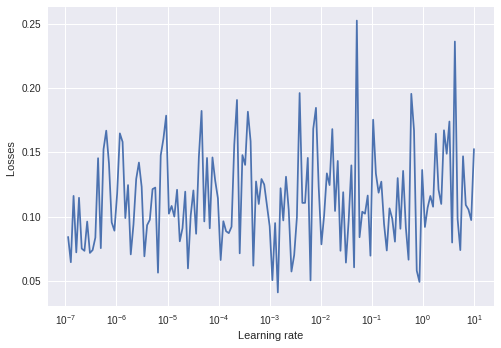

In [0]:
lr_finder.plot()

In [0]:
model= lr_finder.reset()

model reset done


In [0]:
fit_one_cycle = OneCyclePolicy(model ,optimizer , criterion,num_iteration=len(dataloader["train"].dataset)//batch_size  , num_epochs =10, max_lr =1e-3 ,device=device)
fit_one_cycle.train(dataloader["train"],dataloader["val"])

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
Epochs:  10%|█         | 1/10 [00:54<08:06, 54.04s/it]

['train Loss: 0.1154 Acc: 0.9062', 'val Loss: 0.2131 Acc: 0.8711']


Epochs:  20%|██        | 2/10 [01:48<07:12, 54.06s/it]

['train Loss: 0.1149 Acc: 0.9081', 'val Loss: 0.2004 Acc: 0.8650']


Epochs:  30%|███       | 3/10 [02:42<06:18, 54.09s/it]

['train Loss: 0.1150 Acc: 0.9051', 'val Loss: 0.2194 Acc: 0.8678']


Epochs:  40%|████      | 4/10 [03:36<05:24, 54.14s/it]

['train Loss: 0.1212 Acc: 0.9031', 'val Loss: 0.2158 Acc: 0.8671']


Epochs:  50%|█████     | 5/10 [04:30<04:30, 54.14s/it]

['train Loss: 0.1165 Acc: 0.9057', 'val Loss: 0.2198 Acc: 0.8678']


Epochs:  60%|██████    | 6/10 [05:24<03:36, 54.14s/it]

['train Loss: 0.1135 Acc: 0.9043', 'val Loss: 0.2044 Acc: 0.8636']


Epochs:  70%|███████   | 7/10 [06:18<02:42, 54.07s/it]

['train Loss: 0.1169 Acc: 0.9072', 'val Loss: 0.1975 Acc: 0.8581']


Epochs:  80%|████████  | 8/10 [07:12<01:48, 54.08s/it]

['train Loss: 0.1188 Acc: 0.9098', 'val Loss: 0.1890 Acc: 0.8594']


Epochs:  90%|█████████ | 9/10 [08:06<00:54, 54.08s/it]

['train Loss: 0.1115 Acc: 0.9097', 'val Loss: 0.2205 Acc: 0.8678']


Epochs: 100%|██████████| 10/10 [09:00<00:00, 54.07s/it]

['train Loss: 0.1161 Acc: 0.9105', 'val Loss: 0.1962 Acc: 0.8621']


## Visualizing some end result

In [0]:
image , label = next(iter(dataloader["val"]))
image = image.to(device)
label = label.to(device)
output = 0
with torch.no_grad():
  output = model(image)
  output = torch.sigmoid(output)
output = output>0.2  

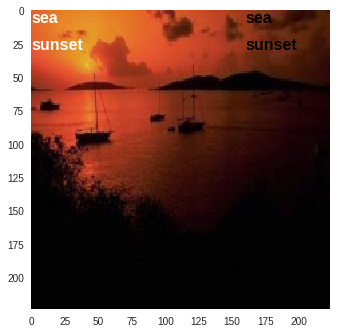

In [0]:
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
  image = image.to("cpu").clone().detach()
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) 
  image = torch.clamp(image,0,1)
  return image.numpy()

def visualize(image , actual , pred):
  fig,ax = plt.subplots()
  ax.imshow(denormalize(image))
  ax.grid(False)
  classes =  np.array(classLabels)[np.array(actual,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
  
  classes =  np.array(classLabels)[np.array(pred,dtype=np.bool)]
  for i , s in enumerate(classes):
    ax.text(160 , i*20  , s , verticalalignment='top', color="black", fontsize=16, weight='bold')

  plt.show()

visualize(image[1] , label[1].tolist() , output[1].tolist())

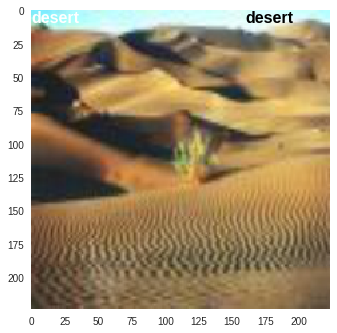

In [0]:
visualize(image[0] , label[0].tolist() , output[0].tolist())

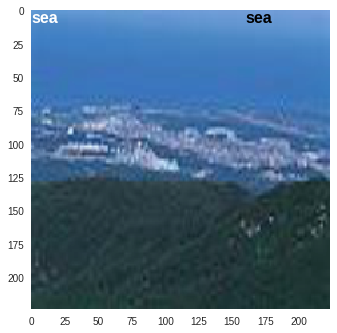

In [0]:
visualize(image[2] , label[2].tolist() , output[2].tolist())

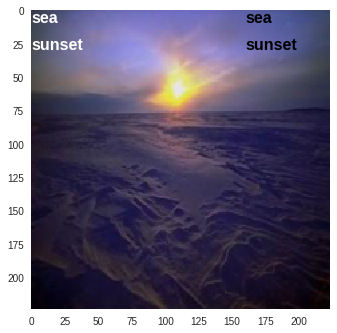

In [0]:
visualize(image[7] , label[7].tolist() , output[7].tolist())

# Summary

## The Final accuracy or more precisely the f1 score is 88.85%
## The loss is 0.1962
